In [1]:
%env CUDA_VISIBLE_DEVICES=1
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
from efficientnet_pytorch import EfficientNet
from torch.utils.data import Dataset, DataLoader
import cv2
import sys
from albumentations import Compose, Normalize, Resize
from albumentations import RandomCrop, HorizontalFlip, VerticalFlip, RandomBrightnessContrast, CenterCrop, PadIfNeeded, RandomResizedCrop
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import os
from glob import glob

env: CUDA_VISIBLE_DEVICES=1


/home/manli/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


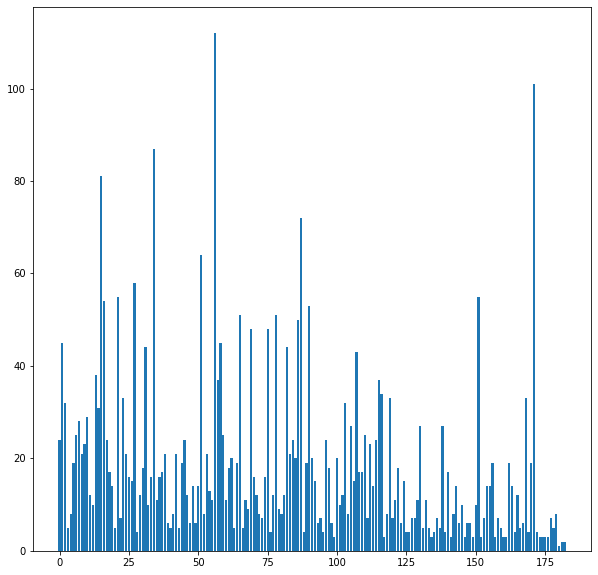

In [2]:
df = pd.read_csv('network/fungi_class_stats.csv')
plt.figure(figsize=(10, 10))
plt.bar(df['class'], df['count'])
plt.show()

In [7]:
print(df['count'])
print(np.sum(df['count']))
print(len(np.where(df['count']<3)[0]))
class_id = np.where(df['count']<3)[0]

0      24
1      45
2      32
3       5
4       8
       ..
178     5
179     8
180     1
181     2
182     2
Name: count, Length: 183, dtype: int64
3366
3


In [11]:
img_df = pd.read_csv('network/data_with_labels.csv')
img_ids = []
for i in class_id:
    img_id = img_df[img_df['class'==i]]['image']
    # print(img_id)
    img_ids.append(img_id)
print(img_ids)
    

KeyError: False

In [15]:
for i_id in class_id:
    bool_select =     

ValueError: ('Lengths must match to compare', (3196,), (33,))

In [16]:
img_dict = dict(zip(list(img_df['image']), list(img_df['class'])))
img_dict

{'/scratch/hilss/DF20M/2237852381-222754.JPG': 0,
 '/scratch/hilss/DF20M/2237852388-108.JPG': 0,
 '/scratch/hilss/DF20M/2237852964-74877.JPG': 1,
 '/scratch/hilss/DF20M/2237853192-298146.JPG': 2,
 '/scratch/hilss/DF20M/2237853950-148876.JPG': 2,
 '/scratch/hilss/DF20M/2237854094-75097.JPG': 2,
 '/scratch/hilss/DF20M/2237854251-223166.JPG': 1,
 '/scratch/hilss/DF20M/2237854576-223245.JPG': 2,
 '/scratch/hilss/DF20M/2237855975-149356.JPG': 1,
 '/scratch/hilss/DF20M/2237857801-223944.JPG': 1,
 '/scratch/hilss/DF20M/2237858626-224115.JPG': 1,
 '/scratch/hilss/DF20M/2237861282-299876.JPG': 3,
 '/scratch/hilss/DF20M/2237862652-300134.JPG': 3,
 '/scratch/hilss/DF20M/2237870260-150860.JPG': 4,
 '/scratch/hilss/DF20M/2237870269-77014.JPG': 5,
 '/scratch/hilss/DF20M/2237883094-77031.JPG': 6,
 '/scratch/hilss/DF20M/2237885623-2662.JPG': 7,
 '/scratch/hilss/DF20M/2237885859-77044.JPG': 8,
 '/scratch/hilss/DF20M/2237887676-225111.JPG': 9,
 '/scratch/hilss/DF20M/2237892546-225139.JPG': 10,
 '/scratc

In [17]:
img_id = list(filter(lambda x: img_dict[x] in class_id, img_dict.keys()))

In [19]:
len(img_id)

109

In [7]:
len(class_id)

78

In [25]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Linear(model._fc.in_features, 183)
x = torch.rand(3, 3, 224, 224)

x = model.extract_features(x)
x = model._avg_pooling(x)
x.shape

Loaded pretrained weights for efficientnet-b0


torch.Size([3, 1280, 1, 1])

In [8]:
np.save('class_id.npy', class_id)

In [ ]:
pool_dataset
for class_id:
    img_id -> img,
    1280dim_repres= model(img)
    img_representation= {'repres'=np.zeros(len(pool_dataset)), 'id'=[]}
    for i,(image, label) in enumerate(pool_dataset):
        fws_pool_repres = model(image)
        img_represetation[i] = fwd_pool_repres         
    distance_tensor = 

In [14]:
#img_df['image'].where(img_df['class'] in class_id)
class_id

array([ 28,  43,  63,  66,  76,  88,  95,  99, 117, 123, 125, 126, 134,
       135, 139, 141, 146, 149, 152, 157, 160, 161, 164, 166, 169, 172,
       173, 174, 175, 176, 180, 181, 182])

In [ ]:
class NetworkFungiDataset(Dataset):
    def __init__(self, file_names, transform=None):
        self.names = file_names
        self.transform = transform

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        file_path = self.names[idx]
        label = 0
        image = cv2.imread(file_path)
        if not isinstance(image, np.ndarray):
            image = np.zeros((512, 512, 3))
            print(file_path)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label
    
def get_transforms(data):
    width = 299
    height = 299

    if data == 'train':
        return Compose([
            RandomResizedCrop(width, height, scale=(0.8, 1.0)),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            RandomBrightnessContrast(p=0.2),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
    elif data == 'valid':
        return Compose([
            Resize(width, height),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
    else:
        print("Unknown data set requested")
        return None

In [17]:
from fungi_classification import get_transforms, 

In [18]:
names = glob(os.path.join('/scratch/hilss/DF20M/*.JPG'))

train_dataset = NetworkFungiDataset(names, transform=get_transforms(data='train'))
# TODO: Divide data into training and validation
valid_dataset = NetworkFungiDataset(names, transform=get_transforms(data='valid'))

trainloader = DataLoader(train_dataset, batch_size=32, num_workers=32, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=32, num_workers=32, shuffle=False)

# batch_sz * accumulation_step = 64
batch_sz = 32
accumulation_steps = 2
n_epochs = 20
n_workers = 8
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Linear(model._fc.in_features, 183)

model.to(device)
    
    
model.load_state_dict(torch.load('network/DF20M-EfficientNet-B0_best_accuracy.pth'))


entropies = []
model.eval()
for image, _ in validloader:
    image = image.to(device)
    out = model(image)# (B, 183)
    # compute entropy
    entropy = -torch.softmax(out, dim=1)*torch.log_softmax(out, dim=1)
    entropy = torch.sum(entropy, dim=1)
    entropies.extend(entropy.flatten().detach().cpu().numpy())

Using device: cuda
Loaded pretrained weights for efficientnet-b0


In [20]:
df = pd.read_csv('network/data_with_labels.csv')
idx = []
for i in range(len(entropies)):
    e = entropies[i]
    name = names[i]
    if name in df['image'].values:
        print(e)
        idx.append(i)

0.4360686
0.42409715
0.98322636
0.8085201
0.17109652
1.2992926
0.24120674
2.7118566
3.986591
0.52486765
0.13887581
2.5334644
3.1089048
0.5752729
2.8911605
1.0361717
0.34239376
1.064648
0.076064855
0.4354536
1.4322984
2.4482508
0.16671026
0.21703954
0.6203304
1.0257242
0.6655632
2.6617813
0.6095364
0.23044832
1.1849806
0.10036811
2.1568706
1.732832
0.568974
3.3620877
2.3989642
0.20581965
0.5964584
0.81329674
1.5213985
0.22445083
0.5560044
2.6470537
2.2471642
1.3774415
1.4141452
0.19139107
0.17502937
2.3599036
0.74193496
0.68623245
2.9191055
0.16910277
0.8709749
0.2113155
0.66756487
0.31431398
0.5935819
1.312425
0.2056327
0.17766917
1.1493437
0.16648817
0.51742554
0.349659
0.55848646
0.51915336
0.16154042
0.6050327
0.45282328
0.62743527
0.4005316
0.35037243
0.22046107
0.67141765
0.37702996
0.1578842
2.1260023
1.5352789
0.07866165
0.10658222
1.5879947
0.19807303
2.5778332
0.17502937
0.049382076
0.17274055
0.91240716
1.7457762
0.51310813
0.63048154
0.9327687
0.93067443
0.8838722
0.7388808


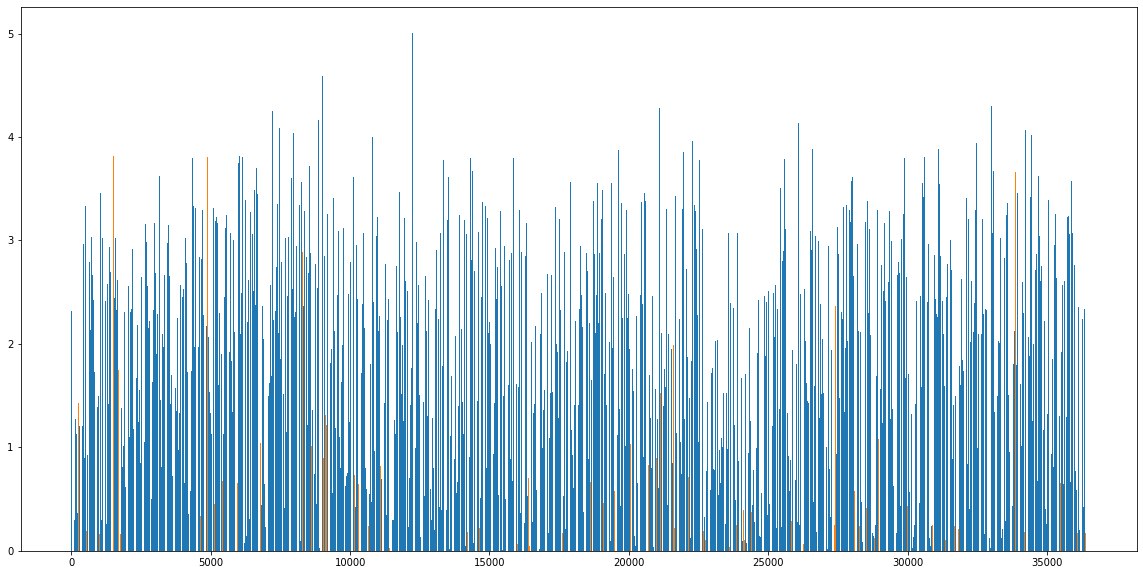

In [21]:
plt.figure(figsize=(20, 10))
plt.bar(np.arange(len(entropies)), entropies)
plt.bar(np.arange(len(entropies))[idx], np.array(entropies)[idx])
plt.show()